# **Feature subset selection with the Genetic Algorithm**

In this notebook, we will use **Genetic Algorithm (GA)** for feature subset selection in a regression problem.

Do our imports.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.linear_model import LinearRegression

from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score

Mount Google Drive so that we can load our dataset.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Load the data.

In [47]:
data = pd.read_csv('/content/drive/MyDrive/ML/auto-lpkm.tsv', sep='\t', header=0)
data

,id,cylinders,displacement,horsepower,weight_lbs,weight_kg,acceleration,model_year,color,more_info_1,more_info_2,more_info_3,more_info_4,more_info_5,l100km
0,0,4,98.0,79,2255,1023,17.7,76,1,94,91,49,97,68,9.0
1,1,4,113.0,95,2278,1033,15.5,72,4,97,58,66,85,38,9.8
2,2,8,351.0,153,4129,1873,13.0,72,1,41,8,15,83,70,16.8
3,3,4,97.0,88,2279,1034,19.0,73,2,53,3,42,2,82,11.8
4,4,6,199.0,97,2774,1258,15.5,70,0,74,53,24,51,53,13.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,195,4,91.0,67,1995,905,16.2,82,4,48,61,22,29,3,6.2
196,196,4,140.0,90,2408,1092,19.5,72,3,81,43,46,100,13,11.8
197,197,4,135.0,84,2370,1075,13.0,82,2,32,57,13,52,6,6.5
198,198,4,91.0,68,2025,918,18.2,82,4,55,88,70,53,54,6.4


The last column is the $y$, i.e., liters per 100 km which we must learn to predict.

In [48]:
X = data.to_numpy()[:, 0:-1]
y = data.to_numpy()[:, -1]
data = data.drop('l100km', axis=1)
feature_names = data.columns.values

In [49]:
X.shape

(200, 14)

In [50]:
feature_names

array(['id', 'cylinders', 'displacement', 'horsepower', 'weight_lbs',
       'weight_kg', 'acceleration', 'model_year', 'color', 'more_info_1',
       'more_info_2', 'more_info_3', 'more_info_4', 'more_info_5'],
      dtype=object)

First we will run the code without the next code cell execution.

Then we will come back here and execute this code to make more features and repeat executing all the next cells.

In [51]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X = poly_features.fit_transform(X)

In [52]:
X.shape

(200, 119)

Create Linear Regression model with all features and evaluate it using Cross-Validation.

In [53]:
model = LinearRegression()

yHat = cross_val_predict(model, X, y, cv=10)

MSE = mean_squared_error(y, yHat)
R2 = r2_score(y, yHat)

print('Result with all features:')
print('MSE: %.3f' % MSE)
print('R^2: %.3f' % R2)

Result with all features:
MSE: 3.880
R^2: 0.735


## **Feature selection with GA**
And now this notebook's most important part – let's implement GA and do feature selection with it.

In [71]:
def GA(X, y, model, feature_names):
  m = X.shape[1]

  # configuration
  pop_size = 10 + 1 # even number plus elite
  num_generations = 30
  crossover_prob = 0.9
  mutation_prob = 1 / m

  # matrices to store the current and the next generation
  pop = np.random.choice(a=[False, True], size=(pop_size, m))
  pop_next = np.empty((pop_size, m), dtype=bool)

  # overall best found soluton
  overall_best_chromosome = np.full(m, False)  # the overall best found solution
  overall_best_fitness = np.inf  # fitness of the best found solution

  # for storing statistics
  stats = np.empty((num_generations, 2))

  # GA generations (iterations)
  for generation in range(0, num_generations):

    # evaluation of each individual
    fitness = np.empty(pop_size)
    for i in range(0, pop_size):
      chromosome = pop[i, :]
      if not np.any(chromosome):
        fitness[i] = np.inf
        continue
      X_selected = X[:, chromosome]
      yHat = cross_val_predict(model, X_selected, y, cv=10)
      fitness[i] = mean_squared_error(y, yHat)

    # find the best individual of the generation
    best_individual = np.argmin(fitness)
    best_fitness = fitness[best_individual]
    best_chromosome = pop[best_individual, :]
    # save best fitness of the generation to stats
    stats[generation] = [np.ma.masked_invalid(fitness).mean(), best_fitness]
    # if better than the overall best, remember it
    if best_fitness < overall_best_fitness:
      overall_best_fitness = best_fitness
      overall_best_chromosome = best_chromosome.copy()

    # print best result in the current generation
    print(f'Generation {generation}: Best fitness = {fitness[best_individual]}')
    if feature_names.shape[0] == m:
      print(''.join(['1' if bit else '0' for bit in pop[best_individual, :]]) + ': ' + '\t'.join(feature_names[pop[best_individual, :]]))
    else:
      print(''.join(['1' if bit else '0' for bit in pop[best_individual, :]]))

    # no need to run the rest of the code for the last generation
    if generation >= num_generations - 1:
      break

    # some preparations for roulette wheel selection
    inverted_fitness = 1 / fitness
    roulette_probs = np.zeros(pop_size)
    roulette_probs[0] = inverted_fitness[0] / np.sum(inverted_fitness)
    for i in range(1, pop_size):
      roulette_probs[i] = roulette_probs[i - 1] + inverted_fitness[i] / np.sum(inverted_fitness)

    # loop through population size with step 2 so that we fully create the next population
    for i in range(0, pop_size - 1, 2):  # -1 because of the elitism
      # roulette wheel selection (finding the first sum of probs that is larger than a random number)
      parent1 = np.argmax(roulette_probs >= np.random.rand())
      parent2 = np.argmax(roulette_probs >= np.random.rand())

      # single-point crossover
      if crossover_prob > np.random.rand():
        crossover_pos = np.random.randint(1, high=m)
        pop_next[i, :] =   np.hstack([pop[parent1, 0:crossover_pos], pop[parent2, crossover_pos:]])
        pop_next[i+1, :] = np.hstack([pop[parent2, 0:crossover_pos], pop[parent1, crossover_pos:]])
      else:
        pop_next[i, :] =   pop[parent1, :]
        pop_next[i+1, :] = pop[parent2, :]

    # elitist
    pop_next[-1, :] = best_chromosome

    # mutation
    mutate = np.random.rand(pop_size, m) <= mutation_prob  # mutation mask for all individuals
    mutate[-1,:] = False  # do not mutate elite
    np.logical_not(pop_next, where=mutate, out=pop_next)

    # the next population becomes the current one
    pop = pop_next.copy()

  # print the overall best result
  print()
  print('Overall best fitness =', overall_best_fitness)
  if feature_names.shape[0] == m:
    print(''.join(['1' if bit else '0' for bit in overall_best_chromosome]) + ': ' + '\t'.join(feature_names[overall_best_chromosome]))
  else:
    print(''.join(['1' if bit else '0' for bit in overall_best_chromosome]))

  # in addition, compute coefficient of determination
  X_selected = X[:, overall_best_chromosome]
  yHat = cross_val_predict(model, X_selected, y, cv=10)
  overall_best_R2 = r2_score(y, yHat)
  print('Overall best R2 =', overall_best_R2)

  return stats, overall_best_R2

Run the function.

In [72]:
stats, R2 = GA(X, y, model, feature_names)

Generation 0: Best fitness = 2.2081001080637686
00111111001010100000101011110111110001000110100111001010110010111000100100010001101101111101100110001011000110000110101
Generation 1: Best fitness = 1.9173417563271427
00111111001010100000101011110111110001000110100111001010100011101101100010111000010110110011101010110001010000010010001
Generation 2: Best fitness = 1.9173417563271427
00111111001010100000101011110111110001000110100111001010100011101101100010111000010110110011101010110001010000010010001
Generation 3: Best fitness = 1.9133513866417167
00111111001010100000101011110111110011000110100111001010100011101101100010111000010110110011101010110001010000010010001
Generation 4: Best fitness = 1.89848840467745
00111111101010100000101011110111110001000110100111001010100011101101100010111000010110110011101000110001010000010010001
Generation 5: Best fitness = 1.889115077726504
0011111100101010000010101111011111000100011010011100101010001110110110001011100000011011001100101011000101000001001

Plot statistics of the algorithm run.

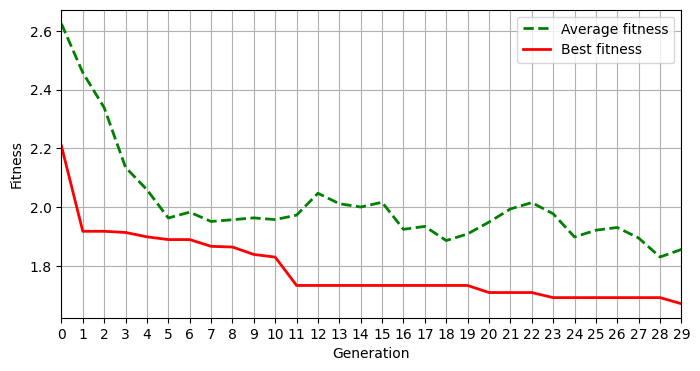

In [73]:
plt.figure(figsize=(8, 4))
generations = range(0, stats.shape[0])
plt.plot(generations, stats[:, 0], "g--", label="Average fitness", linewidth=2)
plt.plot(generations, stats[:, 1], "r-", label="Best fitness", linewidth=2)
plt.grid()
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.xticks(generations)
plt.legend(loc="upper right")
plt.xlim([0, stats.shape[0] - 1])
plt.show()

---
*Notebook by Gints Jēkabsons*